In [2]:
from scipy.stats import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer as Imputer
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
import missingno as msno


csv_data=pd.read_csv(r'D:\A\data\2019_xyk.csv')
df1=csv_data.dropna(axis=1,how='all')   #删除全是空白值的数据

df2=df1.dropna(thresh=0.7*len(df1),axis=1)   #剔除空白值在70%以上的的列

df3=df2.fillna(df2.mean())    #按照每列的均值填充数据
loan=df3

loan['loan_status']=loan['loan_status'].replace(['Fully Paid','In Grace Period','Late (31-120 days)',
                                                 'Late (16-30 days)','Charged Off','Default','Current'],
                                               ['0','1','1','1','1','1','0'])
loan=loan[loan['loan_status'].isin(['0','1'])]
loan['loan_status']=loan['loan_status'].astype('int')

loan['grade']=loan['grade'].replace(['A','B','C','D','E','F','G'],['5','4','3','2','1','0.5','0'])
loan['emp_length']=loan['emp_length'].replace(['< 1 year','1 year','2 years','3 years','4 years','5 years',
                                               '6 years','7 years','8 years','9 years','10+ years'],
                                              ['0','1','2','3','4','5','6','7','8','9','10'])
loan['home_ownership']=loan['home_ownership'].replace(['RENT','MORTGAGE','OWN','ANY'],['3','2','1','0'])
loan['verification_status']=loan['verification_status'].replace(['Source Verified','Verified','Not Verified'],['3','2','1'])
loan['term']=loan['term'].replace(['36 months','60 months'],['1','2'])
oan=loan.drop(['issue_d'],axis=1)
loan.iloc[0]
loan=loan.drop(['purpose'],axis=1)
loan=loan.drop(['addr_state'],axis=1)
loan=loan.drop(['earliest_cr_line'],axis=1)
loan['revol_util'] = loan['revol_util'].str.strip("%").astype(float)/100
loan['int_rate'] = loan['int_rate'].str.strip("%").astype(float)/100
loan=loan.drop(['application_type'],axis=1)
loan['term']=loan['term'].replace([' 36 months',' 60 months'],['1','2'])

loan['sub_grade']=loan['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',
                                            'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2',
                                            'G3','G4','G5'],['7','6.8','6.6','6.4','6.2','6','5.8','5.6','5.4','5.2','5','4.8','4.6','4.4','4.2',
                                            '4','3.8','3.6','3.4','3.2','3','2.8','2.6','2.4','2.2','2','1.8','1.6','1.4','1.2','1','0.8',
                                            '0.6','0.4','0.2'])
loan=loan.drop(['emp_title'],axis=1)
loan=loan.drop(['grade'],axis=1)
loan=loan.drop(['issue_d'],axis=1)
loan=loan.drop(['title'],axis=1)
loan['pymnt_plan']=loan['pymnt_plan'].replace(['n','y'],['1','2'])
loan=loan.drop(['zip_code'],axis=1)
#loan=loan.drop(['next_pymnt_d'],axis=1)
loan['initial_list_status']=loan['initial_list_status'].replace(['f','w'],['1','2'])
loan=loan.drop(['last_pymnt_d'],axis=1)
loan=loan.drop(['last_credit_pull_d'],axis=1)
loan['hardship_flag']=loan['hardship_flag'].replace(['N','Y'],['1','2'])
loan['disbursement_method']=loan['disbursement_method'].replace(['Cash','DirectPay'],['1','2'])
loan['debt_settlement_flag']=loan['debt_settlement_flag'].replace(['N','Y'],['1','2'])
loan=loan.fillna(loan.mode())    #以中位数数填充

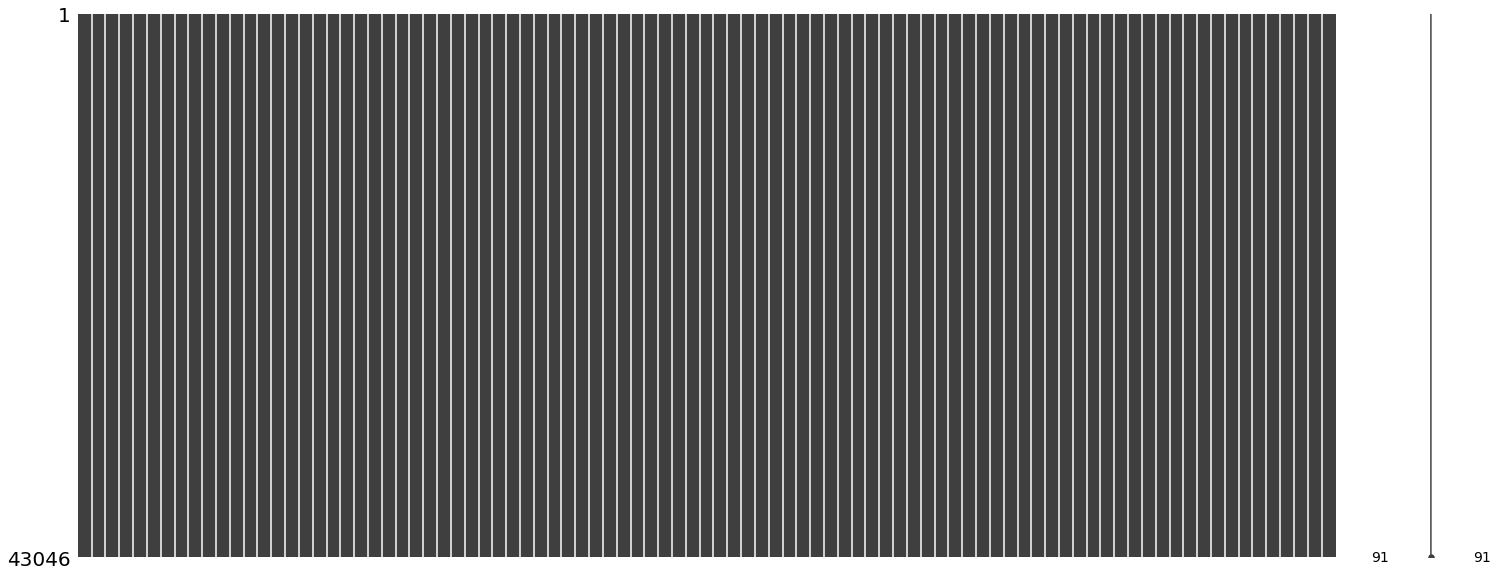

In [3]:
loan=loan.fillna(10)    ##不知道为啥我在用众数填充时，emp_length这一特征总是填不上，所以这个需要你自己先去看看这一列的众数是多少，
                        #然后把10改成你的众数就好

msno.matrix(loan) #这是一个查找空白值的程序，如果程序出来的结果都是一条条黑色的条，那就没问题，如果黑色的条纹中，有白色的横杠，那就是说有空白值
                  #这个需要你先安装missingno的程序包，不想用直接把这两行删掉

In [4]:
loan=loan.drop(["annual_inc", "delinq_2yrs", "revol_bal", "total_acc", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d", "policy_code"],axis=1)
loan_1=loan.copy()


data_1=loan_1[loan_1['loan_status'] == 1]
data_0=loan_1[loan_1['loan_status'] == 0]

data_1_train,data_1_test=train_test_split(data_1,test_size=.3,random_state=12)
data_0_train,data_0_test=train_test_split(data_0,test_size=.3,random_state=12)
train=pd.concat([data_1_train,data_0_train])
test=pd.concat([data_1_test,data_0_test])

train_X=train.drop(['loan_status'],axis=1)
train_y=train['loan_status']
test_X=test.drop(['loan_status'],axis=1)
test_y=test['loan_status']

#resampled_X,resampled_y=SMOTE(random_state=12).fit_sample(train_X,train_y)
rf=RandomForestClassifier(n_estimators=500,max_depth=10,random_state=1).fit(train_X,train_y)
importance=pd.DataFrame({'features':train_X.columns.values,'importance':rf.feature_importances_})
importance.sort_values(by='importance',ascending=False).style.bar()
loan=loan.drop(importance[importance['importance'] < 0.0015]['features'].values,axis=1)#此处的0.0015随你，改成多少都没问题，不过这
                                                                                       #里尽可能小吧，毕竟还要在这里面做相关性，太大了特征太少

In [6]:
def get_next_batch(i_count):
    while True:
        if i_count >= max_batch - 1:
            i_count = int(i_count % max_batch)
        a_x = test_X[i_count * batch_size:(i_count + 1) * batch_size]
        if a_x.shape[0] != 100:
            i_count += 1
            continue
        a_y = train_y[i_count * batch_size:(i_count + 1) * batch_size]
        return a_x, a_y


def get_next_batch_test():
    a_x = train_X[0:100]
    a_y = test_y[0:100]
    return a_x, a_y


def mmscaler(data):
    # feature_range 映射到指定范围
    maxmin = MinMaxScaler(feature_range=[0,1])
    data = maxmin.fit_transform(data)
    return data


df = loan
# 分割数据
train, test = train_test_split(df, test_size=.3, random_state=12)
print(train.shape, test.shape)
train_X = train.drop('loan_status', axis=1)
train_X = mmscaler(train_X)  # 归一化

train_y = np.zeros([train_X.shape[0], 2])
for index, value in enumerate(train['loan_status']):
    if value == 0:
        train_y[index, :] = [1, 0]
    elif value == 1:
        train_y[index, :] = [0, 1]
train_y = pd.DataFrame(train_y)

test_X = test.drop('loan_status', axis=1)
test_X = mmscaler(test_X)
test_y = np.zeros([test_X.shape[0], 2])
for index, value in enumerate(test['loan_status']):
    if value == 0:
        test_y[index, :] = [1, 0]
    elif value == 1:
        test_y[index, :] = [0, 1]
test_y = pd.DataFrame(test_y)

num_classes = 2  # 输出大小
input_size = 65  # 输入大小
hidden_units_size = 30  # 隐藏层节点数量
batch_size = 100

rows_number = train_X.shape[0]
max_batch = int(rows_number / batch_size)

# 随机初始化神经网络的参数
w1 = tf.Variable(tf.random_normal([input_size, hidden_units_size], stddev=1, seed=1))
w2 = tf.Variable(tf.random_normal([hidden_units_size, num_classes], stddev=1, seed=1))
B1 = tf.Variable(tf.constant(0.1), [hidden_units_size])
B2 = tf.Variable(tf.constant(0.1), [num_classes])

# 在shape的一个维度上使用None可以方便使用不同的batch大小。
x = tf.placeholder(tf.float32, shape=(None, input_size), name='x-input')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='y-input')

# 定义计算图
a = tf.matmul(x, w1) + B1
a_r = tf.nn.relu(a)
y = tf.matmul(a_r, w2) + B2

cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))  # 定义交叉熵损失函数
train_step = tf.train.AdadeltaOptimizer(0.001).minimize(cross_entropy)  # 定义优化方法为Ada并最小号cross_entropy

# 计算准确率
origin_y = tf.argmax(y_, axis=1)
predict_y = tf.argmax(y, axis=1)

correct_prediction = tf.equal(origin_y, predict_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 创建一个Session用来执行图
with tf.Session() as sess:
    # 初始化所有的变量
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    STEPS = 10000

    saver = tf.train.Saver()

    if os.path.exists("model/"):
        try:
            saver.restore(sess, "model/")
        # 判断捕获model文件夹中没有模型文件的错误
        except ValueError:
            print("model文件夹为空，将创建新模型")
    else:
        pass

    for i in range(STEPS):
        # 每次选择batch_size个样本进行训练
        start = (i * batch_size) % rows_number
        end = min(start + batch_size, rows_number)
        # 通过选取的样本训练神经网络并更新参数
        _, total_cross_entropy, accuracy_new = sess.run([train_step, cross_entropy, accuracy], feed_dict={x: train_X[start:end], y_: train_y[start:end]})
        # 每1000次输出损失函数的结果
        if i % 1000 == 0:
            print("Loop: {}, loss: {}, acc_train: {}".format(i, total_cross_entropy, accuracy_new))
        if i % 5000 == 0:
            saver.save(sess, "model/")
        accuracy_test = sess.run(accuracy, feed_dict={x: test_X, y_: test_y})
    print("accuracy_test", accuracy_test)


(30132, 65) (12914, 65)


d:\pyinstall\virset\virpy360set\jup\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
d:\pyinstall\virset\virpy360set\jup\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


AttributeError: module 'tensorflow' has no attribute 'Variable'